# Project Image Segmenatation

---
## 0. Imports

In the following cell, add all the imports you'll use in this assignment.

In [31]:
# YOUR CODE HERE
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
# Seaborn is another visualisation module, much like matplotlib
import seaborn as sns
from torch import nn
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import torch.nn.functional as F
from torchvision.transforms import Compose,ToTensor,Normalize, Pad, Resize, RandomHorizontalFlip, RandomRotation
from torch import optim
from torch.utils.data import DataLoader
import statistics as stat
from torchvision.transforms import Compose,ToTensor
from torch.utils.data import DataLoader
torch.cuda.is_available()
from tqdm.auto import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

---
## 1. Loading the data and preprocessing

In this part we will set up the data used in this assignment. You need to download it, then we'll walk you through how to make a custom Pytorch dataset abstraction. The abstraction enables you to visualise and play around with the image data and to finally create data loaders, which are necessary for the training.

Fill in the dataset paths (to be used later by your data loaders):

size of training : 2975
size of cityscapes training : 2975
size of validation : 500
size of cityscapes validation : 500


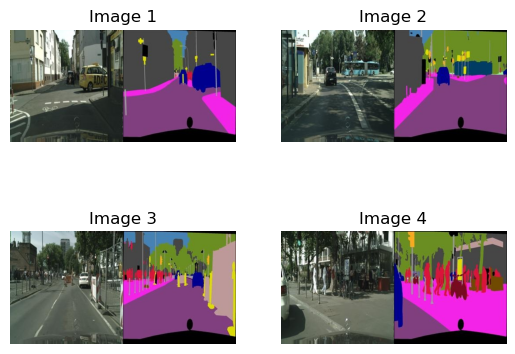

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Directory containing the validation images
train_folder = 'train'
val_folder = 'val'
city_train_folder = 'city_train'
city_val_folder = 'city_val'

# Get a list of file names in the folder
train_files = os.listdir(train_folder)
val_files = os.listdir(val_folder)
city_train_files = os.listdir(city_train_folder)
city_val_files = os.listdir(city_val_folder)

# Create a list of file paths for the validation images
train_path = [os.path.join(train_folder, file) for file in train_files]
val_path = [os.path.join(val_folder, file) for file in val_files]
city_train_path = [os.path.join(city_train_folder, file) for file in city_train_files]
city_val_path = [os.path.join(city_val_folder, file) for file in city_val_files]

print(f"size of training : {len(train_path)}")
print(f"size of cityscapes training : {len(city_train_path)}")
print(f"size of validation : {len(val_path)}")
print(f"size of cityscapes validation : {len(city_val_path)}")

# Plot the first 4 images
for i in range(min(4, len(val_path))):
    img = Image.open(val_path[i])
    plt.subplot(2, 2, i + 1)  # Create a subplot with 2 rows and 2 columns
    plt.imshow(img)
    plt.title(f"Image {i + 1}")
    plt.axis('off')  # Turn off axis labels
plt.show()


# Labels

Assigning colours for each class.

In [23]:
idx_to_name = [ 'unlabeled','ego vehicle','rectification border', 'out of roi', 'static', 'dynamic','ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence','guard rail' , 'bridge','tunnel','pole', 'polegroup', 'traffic light', 'traffic sign' ,'vegetation', 'terrain', 'sky' ,'person', 'rider', 'car','truck' ,'bus', 'caravan','trailer', 'train' , 'motorcycle','bicycle','license plate']
idx_to_category = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

idx_to_color = [[ 0,  0,  0], [ 0,  0,  0], [  0,  0,  0], [  0,  0,  0],[ 0,  0,  0],[111, 74,  0],[81,  0, 81] ,[128, 64,128],[244, 35,232],
                [250,170,160],[230,150,140],[70, 70, 70],[102,102,156],[190,153,153],[180,165,180],[150,100,100],[150,120, 90],[153,153,153],
                [153,153,153],[250,170, 30],[220,220,  0],[107,142, 35],[152,251,152],[ 70,130,180],[220, 20, 60],[255,  0,  0],[ 0,  0,142],
                [ 0,  0, 70],[ 0, 60,100],[ 0,  0, 90],[  0,  0,110],[ 0, 80,100],[  0,  0,230],[119, 11, 32],[  0,  0,142]]


idx_to_color_np = np.array(idx_to_color)

name_to_category = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2,
                    17 : 3, 18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}

size of input :  (256, 256, 3)
size of mask raw :  (256, 256, 3)
size of classes :  (256, 256)


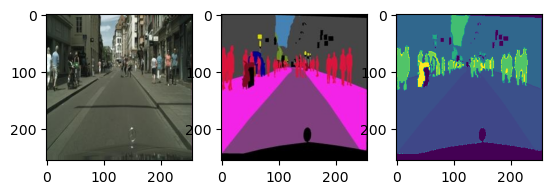

In [26]:
# how many images (total width * height)
width = 4
height = 4
vis_batch_size = width * height

# get vis_batch_size unique, random indices
indexes = np.arange(len(train_path))
indexes = np.random.permutation(indexes)[:vis_batch_size]

from typing import Tuple

# vectorize the operation of getting the name to category for numpy (just a lookup in name_to_category dictionary)
name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)

# vectorize the operation of mapping the name to color for numpy (just a lookup in idx_to_color dictionary)
name_to_col_mapping = lambda x: idx_to_color[x]
vectorized_col_mapping = np.vectorize(name_to_col_mapping)

def preprocess_image(path : str, sparse_mapping=True, downscale_factor=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Read the .jpeg image from *path*. Return the input image (256 x 256 x 3), mask (256 x 256 x 3) read from the jpeg 
        and conversion to categories or names (if sparse_mapping is true) representation (256 x 256 x (|categories| or |names|) )
    """
    # Read the image from path and dowscale if downscale_factor is not None.
    img = Image.open(path)
    width, height = img.size

    if downscale_factor:
        width, height = width // downscale_factor, height//downscale_factor 
        img = img.resize(( width, height ))

    # then split the image into two images (in the middle of width) : input image and color mask (each represented by 3 channels)
    img = np.asarray(img)
    raw, mask = img[:, :width//2, :], img[:, width//2:, :]
    
    height, width, channels = mask.shape

    # compute then the sum of squared distances for each pixel to the colors (L2 between the color and pixel data) : 
    # the value which will be the minimal is the category name we will use for that pixel, and we will get it using argmin
    distances = np.sum((mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np)**2, axis=2)
    classes = np.argmin(distances, axis=1).reshape(height, width)

    # if we want to operate on names, map the categories to names
    if sparse_mapping:
        classes = vectorized_cat_mapping(classes)
    
    return raw, mask, classes


x, mask_raw, classes = preprocess_image(train_path[indexes[i]], sparse_mapping=False, downscale_factor=None)

# sanity checks and print the data
print("size of input : ", x.shape)
print("size of mask raw : ", mask_raw.shape)
print("size of classes : ", classes.shape)
plt.subplot(1, 3, 1)
plt.imshow(x)
plt.subplot(1, 3, 2)
plt.imshow(mask_raw)
plt.subplot(1, 3, 3)
plt.imshow(classes)
plt.show()

# Load Data Set

In [28]:
downscale_factor = None

X_train, Y_train = [], []
X_val, Y_val = [], []

for path in tqdm(train_path[:]):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_train.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_train.append(torch.Tensor(Y))

for path in tqdm(val_path):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_val.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_val.append(torch.Tensor(Y))


  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [30]:
print(f"size of X_train : {len(X_train)} ; Y_train {len(Y_train)}")
print(f"size of X_val : {len(X_val)} ; Y_val {len(Y_val)}")

size of X_train : 2975 ; Y_train 2975
size of X_val : 500 ; Y_val 500


# Normalizing Data 

In [33]:
class CityScapesDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x , y
    
MEAN = [0.485, 0.456, 0.406] # Mean from the image net
STD = [0.229, 0.224, 0.225] # STD from the image net
BATCH_SIZE = 8 # Batch Size


# just normalize the data
preprocess = transforms.Compose([
    transforms.Normalize(mean=MEAN, std=STD),
])

# create the Datasets
train_ds = CityScapesDataset(X_train, Y_train, transform=preprocess)
val_ds = CityScapesDataset(X_val, Y_val, transform=preprocess)

# create the dataloaders
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

# Data visualization

### 1.1 Dataset

To create data loaders we first need to create a dataset abstraction class. The purpose of a data loader is to efficiently provide the CPU/GPU with mini-batches of data. We now work with data complex enough to actually warrant the use of data loaders. In particular, we don't want to load all images into memory at once.

Like before, the data loader is an instance of the Pytorch [`DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) which wraps a class that inherits from [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), that we create ourselves.
Image classification is such a common task that Pytorch provides a ready-to-use dataset class for this task, called [`ImageFolder`](https://pytorch.org/vision/stable/datasets.html?highlight=imagefolder#imagefolder).
Using this class however, is rather opaque so for your understanding we will show you how to construct a custom dataset class. If you know this method, you will be able to create a data loader for any dataset you may encounter.

We construct a class `DogsCatsData` as a subclass of `Dataset`. 
The dataset subclass holds the actual data, or at least provides access to it.
To make it work with the `DataLoader` class we need to implement two methods:

- `__getitem__(self, index)`: return the `index`'th sample, i.e. a single pair of (image, label)
- `__len__(self)`: simply return the total number of samples $N$ in the dataset.

These methods are so called Python "magic" methods, signified by the leading and closing double underscores.
They typically enable special syntax for a class: `__getitem__` enables indexing of a class, and `__len__` enables calling the `len` function:
```python
# Consider an instance `data` of a class `MyDataset` implementing `__getitem__` and `__len__`
data[10] # returns the item with index 10 in `data`
len(data) # returns the length/size of `data`
```
We will return to why these are needed in the `DataLoader` wrapping class

Now, to the actual implementation: The idea is to have the dataset class only store the filenames of the images (and the corresponding label), not the images themselves. We will find and store the filenames in the constructor. The `__getitem__` method will use the index to look up the correct filename and load it into memory.
The `__len__` method is left for you to implement.

Being able to use and understand code you have not written is an important ability. Below you are required to interact with the dataset class with a simple completion of the implementation and by extracting some data from the class. This is partly to ensure that you understand this specific class and partly to show you some tools for exploring new code.

In [28]:
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image

class DogsCatsData(Dataset):
    
    def __init__(self, root, transform, dog_label=1, cat_label=0):
        """Constructor
        
        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """
        
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")
            
        self.root = root
        self.transform = transform
        self._dog_label = dog_label
        self._cat_label = cat_label
        
        # Collect samples, both cat and dog and store pairs of (filepath, label) in a simple list.
        self._samples = self._collect_samples()
            
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label
    
    def __len__(self):
        """Total number of samples"""
        # YOUR CODE HERE
        return len(self._samples)
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        # Iterator over dog filpath
        dog_paths = self._collect_imgs_sub_dir(self.root / "dogs")
        # Iterator of pairs (path, dog label)
        # Again, we use the `map` function to create an iterator. It's use is not as common as the so called
        # 'list comprehension' you've previously seen, but a good alternative to have seen.
        dog_paths_and_labels = map(lambda path: (path, self._dog_label), dog_paths)
        # Same for cats
        cat_paths = self._collect_imgs_sub_dir(self.root / "cats")
        cat_paths_and_labels = map(lambda path: (path, self._cat_label), cat_paths)
        # Sorting is not strictly necessary, but filesystem globbing (wildcard search) is not deterministic,
        # and consistency is nice when debugging.
        return sorted(list(chain(dog_paths_and_labels, cat_paths_and_labels)), key=lambda x: x[0].stem)
     
    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.jpg")
    
    def get_sample_by_id(self, id_):
        """Get sample by image id
        
        Convenience method for exploration.
        The indices does not correspond to the image id's in the filenames.
        Here is a (rather inefficient) way of inspecting a specific image.
        
        Args:
            id_ (str): Image id, e.g. `dog.321`
        """
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]


**(2 points)**

Show that you understand the implementation by creating an instance called `example_dataset` of it. Create it from the small training set.
Use the instance to
 1. Print the number of samples in it
 2. Print the label of the second sample, note that this is a number (0 or 1)

In [29]:
from torchvision.transforms import Compose,ToTensor
transform = Compose([ToTensor()])
# YOUR CODE HERE

example_dataset = DogsCatsData(small_train_path,transform)
print("Number of samples: ", len(example_dataset))
print("The label of the second sample : " , example_dataset[1][1])


Number of samples:  3500
The label of the second sample :  0


It is vital to explore your data, but it can be tricky to deal with images in the tensor format.
To aid you, use the below helper function to visually inspect your images.

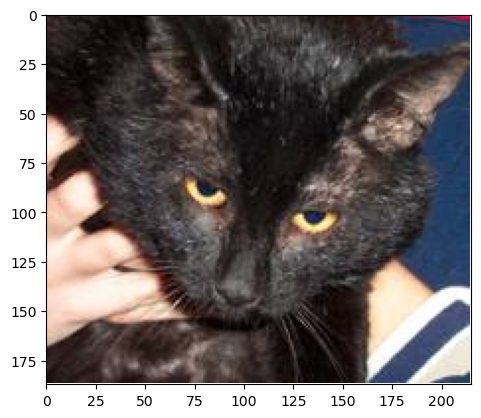

In [30]:
def display_image(axis, image_tensor):
    """Display a tensor as an image
    
    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """
    
    # See hint above
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")
        
    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.
    axis.set_ylim(height, 0)

# Example usage
_, axis = plt.subplots()
some_random_index = 453
# Here we use the __getitem__ method as a "magic" method.
# Implementing it for a class, enables square bracket '[]' indexing
image_tensor, label = example_dataset[some_random_index]
display_image(axis, image_tensor)

### 1.2 Preprocessing 
The `DogsCatsData` class constructor has an argument called `transform`. It allows us to transform or preprocess all the images in a batch, from the raw image data to a more suitable format. There are multiple motivations for preprocessing:

- Some transformations might be needed to actually make the data work with our network (reshaping, permuting dimensions et c.).
- Make the training more efficient by making the input dimensions smaller, e.g. resizing, cropping.
- Artificially expanding the training data through [data augmentation](https://cartesianfaith.com/2016/10/06/what-you-need-to-know-about-data-augmentation-for-machine-learning/)
- We have some clever idea of how to change the data to create a simpler optimisation problem.

We do not expect you to do data augmentation, but feel free to preprocess the data as you see fit. Use the [documentation](https://pytorch.org/vision/stable/transforms.html#torchvision-transforms) to view available transforms. Extra important is the `Compose` transformation, which is a meta-transformation which composes actual ones, and the `ToTensor` transformation which is the simplest way to go from image to tensor format.


Hints:
- Revisit the `DogsCatsData` example usage to see how to use the `Compose` and `ToTensor` transformations.
- When feeding the images to your CNN, you'll probably want all of them to have the same spatial size, even though the .jpeg files differ in this. Resizing the images can be done using the previously mentioned Pytorch Transforms.
- Resizing the images to a smaller size while loading them can be beneficial as it speeds up training. The CNN's do surprisingly well on 64x64 or even 32x32 images. Shorter training cycles give you more time to experiment! Note: The VGG network used later in this assignment is specialised for images that are 224x224.

We encourage you to explore the data and choose transformations that you believe to be useful. For exploration we provide you with a helper function to visually compare transformations side by side:

In [17]:
def compare_transforms(transformations, index):
    """Visually compare transformations side by side.
    Takes a list of DogsCatsData datasets with different compositions of transformations.
    It then display the `index`th image of the dataset for each transformed dataset in the list.
    
    Example usage:
        compare_transforms([dataset_with_transform_1, dataset_with_transform_2], 0)
    
    Args:
        transformations (list(DogsCatsData)): list of dataset instances with different transformations
        index (int): Index of the sample in the dataset you wish to compare.
    """
    
    # Here we combine two functions from basic python to validate the input to the function:
    # - `all` takes an iterable (something we can loop over, e.g. a list) of booleans
    #    and returns True if every element is True, otherwise it returns False.
    # - `isinstance` checks whether a variable is an instance of a particular type (class)
    if not all(isinstance(transf, Dataset) for transf in transformations):
        raise TypeError("All elements in the `transformations` list need to be of type Dataset")
        
    num_transformations = len(transformations)
    fig, axes = plt.subplots(1, num_transformations)
    
    # This is just a hack to make sure that `axes` is a list of the same length as `transformations`.
    # If we only have one element in the list, `plt.subplots` will not create a list of a single axis
    # but rather just an axis without a list.
    if num_transformations == 1:
        axes = [axes]
        
    for counter, (axis, transf) in enumerate(zip(axes, transformations)):
        axis.set_title(f"transf: {counter}")
        image_tensor = transf[index][0]
        display_image(axis, image_tensor)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mean and std before normalize:
Mean of the image: tensor([0.4504, 0.4339, 0.4522])
Std of the image: tensor([0.2477, 0.2079, 0.1854])


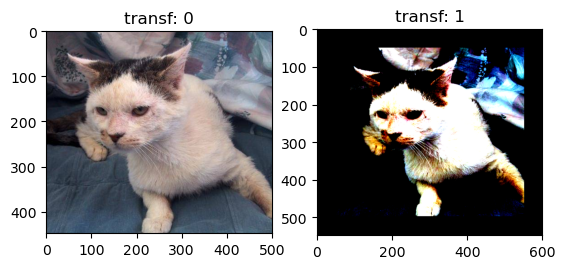

In [14]:
# Explore your dataset in this cell, you do not need to produce any results.
# YOUR CODE HERE
#from torchvision.transforms import Compose,ToTensor,Normalize, Pad
example_dataset = DogsCatsData(small_train_path,transform)
img_tr,lab = example_dataset.__getitem__(2)
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)
transform2 = Compose([ToTensor(),Normalize(mean, std), Pad(50)])
example_dataset2 = DogsCatsData(small_train_path,transform2)
compare_transforms([example_dataset,example_dataset2],2)

**(2 points)**

Normalisation of the training data is popular in pre-processing. What is the argument or intuition for why this is a beneficial transformation?

**Your answer:** (fill in here)
Normalizing is mainly used to improve the training stability of neural networks. This is mainly done by scaling all features to a common range, between 0 and 1, which helps train according to all features equally. Normalization helps in generalizing unseen data and thus redcing the risk of overfitting. Normalization also speeds up the convergence during iterative processes.

### 1.3 Data loaders
With our dataset class implementation in place, creating a `DataLoader` instance is simple.

The data loader class wraps the dataset and provides a way to iterate over batches in the training loop.
To produce batches, it gets the total number of samples $N$ with the dataset's `__len__` method.
It divides the indices $1, \dots, N$ into equally sized index batches with $B$ (batch size) elements. A particular batch with pairs of image and label is created by calling the dataset's `__getitem__` method with the indices in the batch. NB: the last batch in an epoch might be smaller if $N$ is not divisible by $B$.

Create the data loaders needed for training (use the small version of the data), in the cell below.
The `DataLoader` class is documented [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) , but it's not that much to it.
You simply create a data loader with a dataset instance and some other (self-explanatory) settings:

```python
train_dataloader = DataLoader(example_dataset, batch_size=batch_size, shuffle=True)
```

**(1 point)**

Create data loaders required for training and validation.

Hints:
- The specified `batch_size` should be chosen so that you train fast but don't run out of memory. You need to figure this out empirically; start small and increase the batch size until you run out of memory. Beyond this pragmatic approach, feel free to contribute to the highly contested scientific debate about the relation between batch size and generalisation.
- The `DataLoader` constructor takes an optional argument `num_workers`, which defaults to `0` if not provided. Setting a higher number creates multiple threads which load batches concurrently. This can speed up training considerably.

In [18]:

train_dataloader = DataLoader(example_dataset, batch_size=200, shuffle = True, num_workers = 2)
example_dataset3 = DogsCatsData(small_val_path,transform)
val_dataloader = DataLoader(example_dataset3, batch_size=200, shuffle=True, num_workers=2)


---
## 2. Training

### 2.1 The first model

**(3 points)**

Now, it's time to create a model called `FirstCnn`. To begin with, you have to create a CNN to an exact specification. After that, you will get the chance to be more creative.

For the first model, create a network that:
- Inherits from [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)
- Implements a constructor `__init__(self, img_size)`, a `forward(self, input_batch)` method and whatever other helper methods you deem necessary. Note that a (square) image size should be a parameter in the model's constructor. While not strictly necessary, it is an acceptable way of handling varying input dim's and it is convenient for testing.
- Can handle square images of arbitrary size and arbitrary large mini-batch sizes (within memory limits, of course). You may assume that there are always three colour channels, i.e., a mini-batch will have the shape `(batch size = B, num channels = 3, img size = D, D)`
- Has layers:
    1. Two convolutional layers, each with 10 filters, kernel size = 3, stride = 1, padding = 0
    2. A single fully connected layer.
- Related layers such as a pooling operation are optional.
- Choose suitable activation functions
- Outputs the probability of the image belonging to the class 'dog'. Technically the output should consist of `B` probabilities, one for each image in the mini-batch and so have the shape `(B,)`.

Hints:

- The subpage for [`torch.nn`](https://pytorch.org/docs/stable/nn.html) is a good place to find the layer specifics.
- Going from the last CNN layer to the final fully connected layer is not trivial. The convolutions produces feature maps which we can think of as an image with many channels, while the fully connected layer expects a row vector as input. Calculate how many output neurons the convolutions produce and use `.reshape` to make your tensor fit the fully connected layer. It is also common to see the `.view` and `.squeeze` methods to do the same thing. They basically do the same thing (apart from some differences in internal memory management) but are less transparent. *Hint within the hint:* remember that the fully connected layers expects a *batch* of 1D tensors. 


In [19]:
# YOUR CODE HERE

class FirstCnn(nn.Module):
    
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size
        self.cv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.cv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear((self.img_size-4)*(self.img_size-4)*10//16, 1)

    def forward(self, input_batch):
        x = F.relu(self.cv1(input_batch))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.cv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=1)
        x = x.view(-1, (self.img_size-4)*(self.img_size-4)*10//16)
        x = self.fc1(x)
        #print(torch.sigmoid(np.squeeze(x)))
        return torch.sigmoid(np.squeeze(x))



In [45]:
def test_model(model_class):
    assert issubclass(model_class, nn.Module), "Model class should inherit from nn.Module"
    
    assert getattr(model_class, "forward", None) is not None, "Model class should have a 'forward' method"
    
    _test_output(model_class, some_img_size=224, some_batch_size=64)
    _test_output(model_class, some_img_size=32, some_batch_size=8)
    
    print("Test passed.")

def _test_output(model_class, some_img_size, some_batch_size):
    random_input = torch.rand(some_batch_size, 3, some_img_size, some_img_size)
    model_instance = model_class(img_size=some_img_size)
    output = model_instance.forward(random_input)
    output_shape = list(output.shape)
    assert output_shape == [some_batch_size], f"Expected output size [{some_batch_size}], got {output_shape}"
    
# Note that the test takes the actual class, not an instance of it, as input.
# Here, we assume that the model class is named 'FirstCnn'
test_model(FirstCnn)

Test passed.


**(3 points)**

You have been told that one of the benefits of CNN is that it can handle input of different sizes. Yet, you needed to know the image size in the constructor.
Explain how you made your model handle different input sizes and why it is necessary, despite it being a CNN.

**Your answer:** (fill in here)
The convoluted neural network has layers usually divided as convoluted layers and fully connected layers. The fully convoluted layers are generally towards the end of the network. Although the convoluted layers can handle varying input size, the fully connected layers require it for their neurons to the weights defined here need the information to create the input and output connection.

### 2.2 The training loop

**(1 point)**

You have already seen quite a few training loops in the preparations. Below we provide you with an example of a basic one that you can use.
You need to provide an implementation that maps network outputs (probabilites) to hard labels.

An extra point is awarded if you provide a vectorised implementation.

In [46]:
def output_to_label(z):
    """Map network output z to a hard label {0, 1}
    
    Args:
        z (Tensor): Probabilities for each sample in a batch.
    Returns:
        c (Tensor): Hard label {0, 1} for each sample in a batch
    """
    # YOUR CODE HERE
    return (z >=0.5).long()

    
def test_output_to_label(fn):
    batch_size = torch.randint(1, 64, (1,))
    random_logits = torch.rand(batch_size)
    random_probs = random_logits / random_logits.sum()
    labels = fn(random_probs)
    assert labels.shape == random_logits.shape, "The element-wise function should preserve the shape"
    assert labels.dtype == torch.long, "Incorrect datatype, should be torch.long"
    fixed_logits = torch.tensor([0.1, 0.9, 0.51, 0.49, 0.7])
    fixed_labels = torch.tensor([0, 1, 1, 0, 1], dtype=torch.long)
    assert all(fixed_labels == fn(fixed_logits)), "Incorrect fixed output"
    assert fixed_logits.device == fixed_labels.device, "Make sure that the output tensor is on the same device"
    print("Test passed!")

test_output_to_label(output_to_label)

Test passed!


In [47]:
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)

    if torch.cuda.is_available():

        print("Using GPU")

    else:

        print("Using CPU")
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.float())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)

**(1 point)**

Use the training loop to train your model, using the two data loaders you created earlier. Train for a reasonable amount of epochs, so as to get a good sense of how well this architecture performs.

Hints:
- Training on a CPU is slow and in the beginning you just want to verify that your architecture actually produces a predicition with the correct shape. Make everything you can to speed up the prototyping phase, e.g. train only for a single epoch and make the images ridiculously small.

In [48]:
# YOUR CODE HERE
#from torchvision.transforms import Compose,ToTensor,Normalize, Pad, Resize
#from torch import optim


transform2 = Compose([ToTensor(), Pad(50), Resize((64,64))])
train_dataset = DogsCatsData(small_train_path,transform2)
val_dataset = DogsCatsData(small_val_path,transform2)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

model = FirstCnn(64)
# We provide the `Adam` optimizer with the model parameters,
# effectively telling it which parameters we consider trainable.
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss() #computes the softmax and loss function

first_model, train_losses, train_accs, val_losses, val_accs = training_loop(model, optimizer, loss_fn, train_dataloader, val_dataloader, 15, 10)


Starting training
Using GPU


/home/student/conda/envs/dml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Batch 10/55: 	Train loss: 133.475, 	Train acc.: 0.517, 	Val. loss: 129.377, 	Val. acc.: 0.503
	Batch 20/55: 	Train loss: 132.668, 	Train acc.: 0.498, 	Val. loss: 129.517, 	Val. acc.: 0.499
	Batch 30/55: 	Train loss: 126.430, 	Train acc.: 0.475, 	Val. loss: 129.448, 	Val. acc.: 0.501
	Batch 40/55: 	Train loss: 140.153, 	Train acc.: 0.527, 	Val. loss: 129.550, 	Val. acc.: 0.498
	Batch 50/55: 	Train loss: 131.139, 	Train acc.: 0.503, 	Val. loss: 129.055, 	Val. acc.: 0.514
Epoch 1/15: Train loss: 132.100, Train acc.: 0.506, Val. loss: 129.499, Val. acc.: 0.501
	Batch 10/55: 	Train loss: 132.666, 	Train acc.: 0.502, 	Val. loss: 129.345, 	Val. acc.: 0.497
	Batch 20/55: 	Train loss: 135.579, 	Train acc.: 0.491, 	Val. loss: 129.380, 	Val. acc.: 0.497
	Batch 30/55: 	Train loss: 131.005, 	Train acc.: 0.508, 	Val. loss: 129.586, 	Val. acc.: 0.503
	Batch 40/55: 	Train loss: 135.995, 	Train acc.: 0.489, 	Val. loss: 129.621, 	Val. acc.: 0.503
	Batch 50/55: 	Train loss: 135.580, 	Train acc.: 0.491, 

### 2.3 Visualisation

**(1 point)**

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.
Note that the given training loop produces metrics at different intervals for training and validation, make sure that you align your metrics in a way that makes sense.

825
15


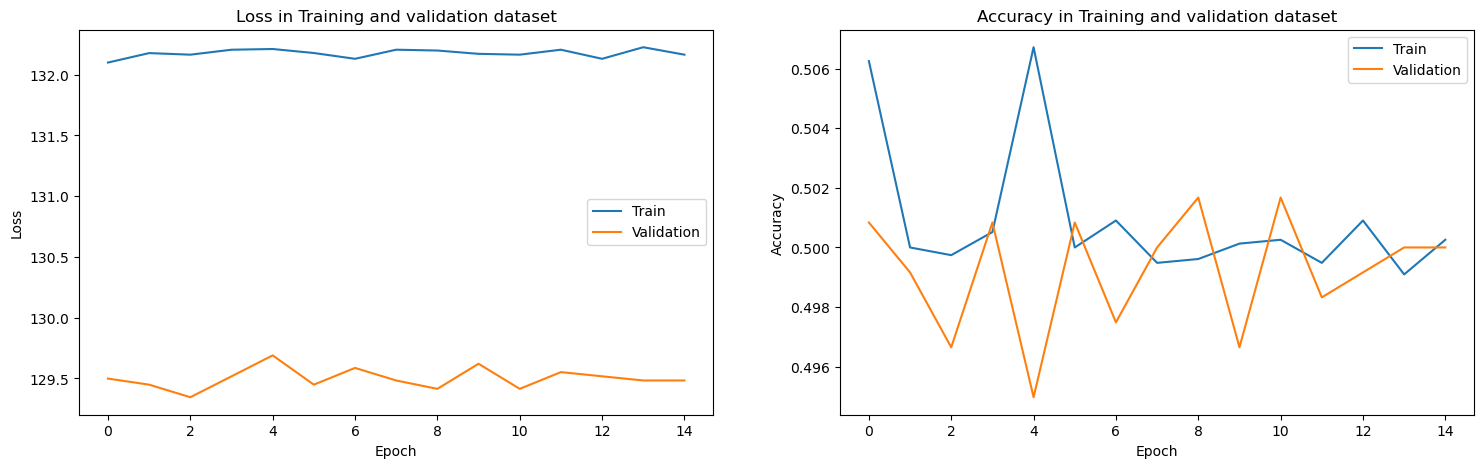

In [50]:
# YOUR CODE HERE


print(len(train_losses))
print(len(val_losses))
#train_losses_plt = [stat.mean(val_losses[0:49])]
#print(stat.mean(val_losses[0:5]))
train_means = [stat.mean(train_losses[i:i+int(len(train_losses)/len(val_losses))]) for i in range(0, len(train_losses), int(len(train_losses)/len(val_losses)))]
train_accs_means = [stat.mean(train_accs[i:i+int(len(train_losses)/len(val_losses))]) for i in range(0, len(train_accs), int(len(train_losses)/len(val_losses)))]
fig = plt.figure(figsize=(18,5))


# Plot for loss in the training and validation datasets
plt.subplot(1,2,1)
plt.plot(train_means)
plt.plot(val_losses)
plt.title('Loss in Training and validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot for accuracy in the training and validation datasets
plt.subplot(1,2,2)
plt.plot(train_accs_means)
plt.plot(val_accs)
plt.title('Accuracy in Training and validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# printing the corresponding plots
plt.show()

**(2 points)**

Based on these, what would you suggest for improving your model? Why?

**Your answer:** (fill in here)
There are multiple ways to improve the model to train better and reduce losses. There are as follows,
- increase the depth of the network.
- By first increasing the number of channels as the layers increase and to the end downscale it again. This is recommended for better training.
- Make the input dataset more unconventional by using transforms like Rotation and horizontal flipping.
- Reducing the learning rate, thus reducing the loss more smoothly and sequentially.

[Save your model](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to disk (the architecture, weights, optimizer state, losses and accuracies). This is simply so you can use it again easily in the later parts of the notebook, without having to keep it in memory or re-training it. The actual file you create is not relevant to your submission. The code to save the model is given in the cell below.

In [49]:
# Assuming that you named your model "first_model"
torch.save({'model_state_dict': first_model.state_dict(),
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_losses': val_losses,
            'val_accs': val_accs,
            }, "./first_model.ckpt")

# Example of creating and initialising model with a previously saved state dict:
#saved_first_model = FirstCnn() # fill-in the arguments if needed
#checkpoint = torch.load("first_model.ckpt")
#saved_first_model.load_state_dict(checkpoint['model_state_dict'])

# Example of re-using saved statistics:
#print("Validation accuracies:", checkpoint['val_accs'])

---
## 3. Improving your model

**(3 points)**

Now you are free to create whichever model you want. A simple improvement based on your analysis of the above results is fine, or you can do something more ambitious. When you're happy with one architecture, copy it in the cell below and train it here. Save the training and validation losses and accuracies. You'll use this later to compare your best model with the one using transfer learning. *Hint*: reducing the input image size facilitates training.

**Note**: When trying different ideas, you'll end up with several different models. However, when submitting your solutions to Canvas, the cell below must contain only the definition and training of *one* model. Remove all code related to the models that were not chosen.

In [51]:
# YOUR CODE HERE
#from torchvision.transforms import Compose,ToTensor,Normalize, Pad, Resize, RandomHorizontalFlip, RandomRotation


class SecondCnn(nn.Module):
    
    def __init__(self, img_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (img_size // 8) * (img_size // 8), 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(np.squeeze(x))
    

#transform_sec = Compose([ToTensor(), Resize((64,64)), Normalize(mean, std), ])
transform_sec = Compose([Resize((64, 64)), RandomHorizontalFlip(),RandomRotation(10),ToTensor(),Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset_sec = DogsCatsData(small_train_path,transform_sec)
val_dataset_sec = DogsCatsData(small_val_path,transform_sec)

train_dataloader_sec = DataLoader(train_dataset_sec, batch_size=64, shuffle = True)
val_dataloader_sec = DataLoader(val_dataset_sec, batch_size=64, shuffle=True)

model = SecondCnn(64)
# We provide the `Adam` optimizer with the model parameters,
# effectively telling it which parameters we consider trainable.
optimizer = optim.Adam(model.parameters(), lr=0.001)
#loss_fn = loss_fn = nn.CrossEntropyLoss() #computes the softmax and loss function
loss_fn = nn.BCELoss()

second_model, train_losses_sec, train_accs_sec, val_losses_sec, val_accs_sec = training_loop(model, optimizer, loss_fn, train_dataloader_sec, val_dataloader_sec, 15, 10)
    


Starting training
Using GPU
	Batch 10/55: 	Train loss: 0.751, 	Train acc.: 0.517, 	Val. loss: 0.692, 	Val. acc.: 0.545
	Batch 20/55: 	Train loss: 0.694, 	Train acc.: 0.523, 	Val. loss: 0.690, 	Val. acc.: 0.500
	Batch 30/55: 	Train loss: 0.687, 	Train acc.: 0.527, 	Val. loss: 0.683, 	Val. acc.: 0.539
	Batch 40/55: 	Train loss: 0.681, 	Train acc.: 0.567, 	Val. loss: 0.659, 	Val. acc.: 0.634
	Batch 50/55: 	Train loss: 0.670, 	Train acc.: 0.583, 	Val. loss: 0.644, 	Val. acc.: 0.641
Epoch 1/15: Train loss: 0.693, Train acc.: 0.547, Val. loss: 0.642, Val. acc.: 0.656
	Batch 10/55: 	Train loss: 0.654, 	Train acc.: 0.633, 	Val. loss: 0.686, 	Val. acc.: 0.549
	Batch 20/55: 	Train loss: 0.643, 	Train acc.: 0.634, 	Val. loss: 0.624, 	Val. acc.: 0.657
	Batch 30/55: 	Train loss: 0.631, 	Train acc.: 0.659, 	Val. loss: 0.644, 	Val. acc.: 0.633
	Batch 40/55: 	Train loss: 0.661, 	Train acc.: 0.628, 	Val. loss: 0.619, 	Val. acc.: 0.673
	Batch 50/55: 	Train loss: 0.603, 	Train acc.: 0.673, 	Val. loss: 0.

**(1 point)**

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

825
15


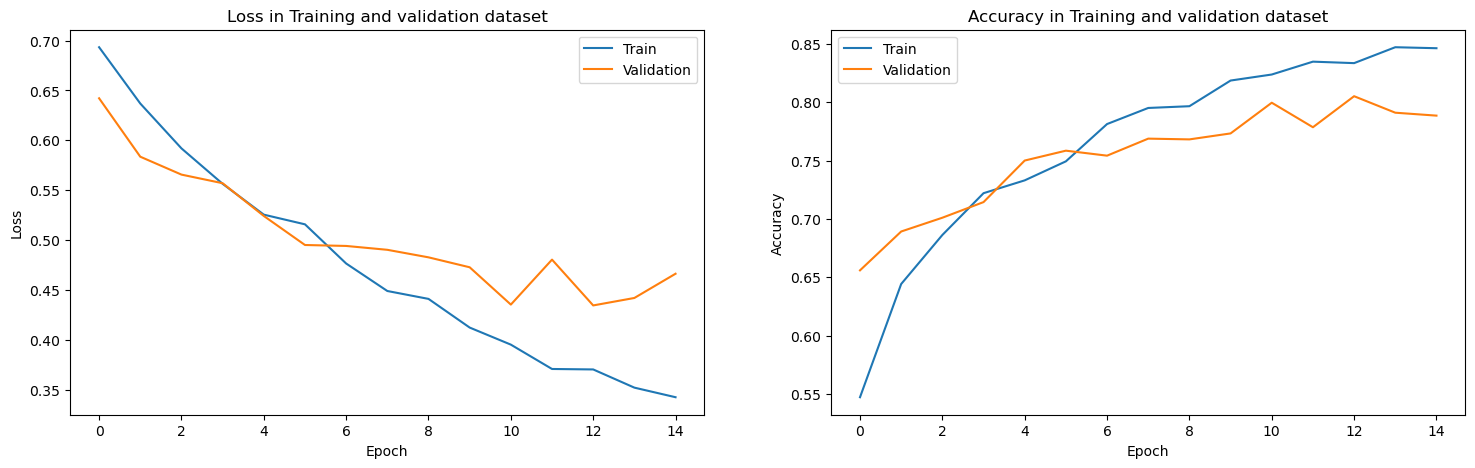

In [53]:
# YOUR CODE HERE
#import statistics as stat

print(len(train_losses_sec))
print(len(val_losses_sec))

train_sec_means = [stat.mean(train_losses_sec[i:i+int(len(train_losses_sec)/len(val_losses_sec))]) for i in range(0, len(train_losses), int(len(train_losses_sec)/len(val_losses_sec)))]
#print(len(train_means))
train_accs_sec_means = [stat.mean(train_accs_sec[i:i+int(len(train_losses_sec)/len(val_losses_sec))]) for i in range(0, len(train_accs), int(len(train_losses_sec)/len(val_losses_sec)))]
fig = plt.figure(figsize=(18,5))


# Plot for loss in the training and validation datasets
plt.subplot(1,2,1)
plt.plot(train_sec_means)
plt.plot(val_losses_sec)
plt.title('Loss in Training and validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot for accuracy in the training and validation datasets
plt.subplot(1,2,2)
plt.plot(train_accs_sec_means)
plt.plot(val_accs_sec)
plt.title('Accuracy in Training and validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# printing the corresponding plots
plt.show()

**(1 point)**

How does the model perform, compared to the first CNN model? Create one plot with the training accuracy and another with the validation accuracy of the two models.

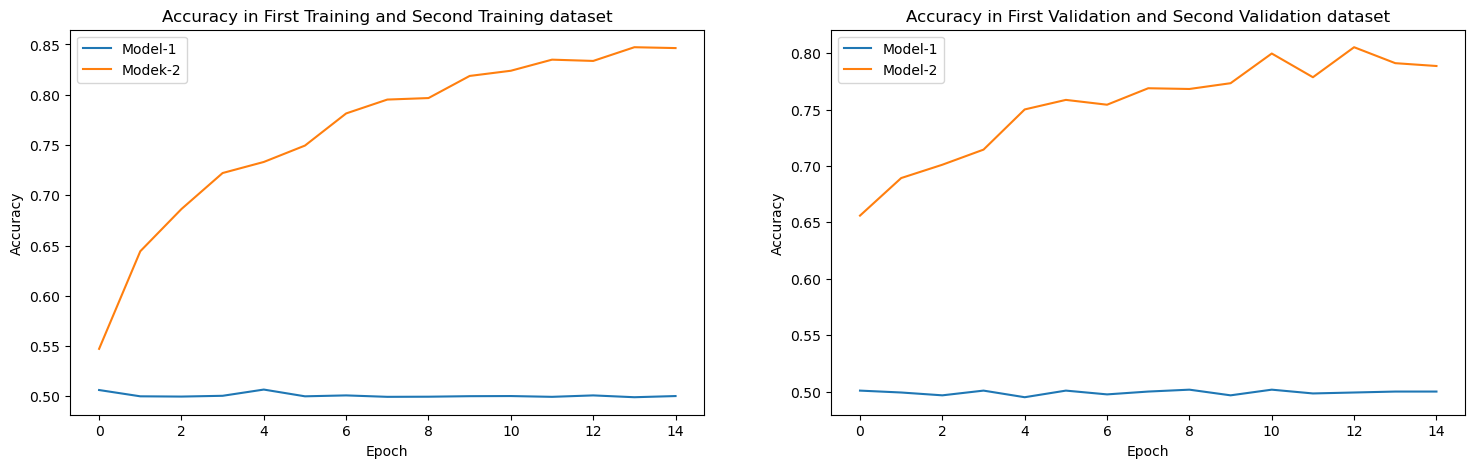

In [54]:
# YOUR CODE HERE

fig = plt.figure(figsize=(18,5))

# Plot for accuracy in the first training_1 and second training_2 datasets
plt.subplot(1,2,1)
plt.plot(train_accs_means)
plt.plot(train_accs_sec_means)
plt.title('Accuracy in First Training and Second Training dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Model-1', 'Modek-2'])

# Plot for accuracy in the first validation and second validation datasets
plt.subplot(1,2,2)
plt.plot(val_accs)
plt.plot(val_accs_sec)
plt.title('Accuracy in First Validation and Second Validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Model-1', 'Model-2'])

# printing the corresponding plots
plt.show()


**(3 points)**

Did your results improve? What problems did your improvements fix? Explain why, or why not. 

**Your answer:** (fill in here)
There was a major improvement in the performance of the network. As you can see from the graphs above, the accuracy on an average resulted at 80% compared to the first model being only 50%. The improvements we commend upon are,
- The deeper network created more weights to add more features and train accordingly.
- The Randomrotating and flipping, creates the images to appear non-conventionally, making the image appear in different scenarios to the model to train upon. This trains the model not to overfit and create more flexible weights.
- By reducing the learning rate, the loss function does not jump in large magnitudes, but move slowly towards the optimal.

Save your model to disk.

In [55]:
# Assuming that you named your model "impr_model"
torch.save({'model_state_dict': second_model.state_dict(),
            'train_losses': train_losses_sec,
            'train_accs': train_accs_sec,
            'val_losses': val_losses_sec,
            'val_accs': val_accs_sec,
            }, "./second_model.ckpt")

In [ ]:
# YOUR CODE HERE

---
## 4. Transfer Learning

**From now, training on a CPU will likely not be feasible. If your computer has a GPU, try it out! Otherwise, now is the time to connect to your cloud instance**

Now, instead of trying to come up with a good architecture for this task, we'll use the VGG16 architecture, but with the top layers removed (the fully connected layers + softmax). We'll substitute them with our own top network, designed for dog/cat classification.
This top network is often called the "head" in transfer learning.

However, this model has a very high capacity, and will probably suffer a lot from overfitting if we try to train it from scratch, using only our small subset of data. Instead, we'll start the optimization with the weights obtained after training VGG16 on the ImageNet dataset.

Start by loading the *pretrained* VGG16 model, from the [torchvision.models](https://pytorch.org/vision/stable/models.html?highlight=vgg#torchvision.models.vgg16).

In [16]:
from torchvision import models
vgg_model = models.vgg16(weights=models.VGG16_Weights)
print(vgg_model.classifier)

/home/student/conda/envs/dml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


**(1 point)**

Create a new model as a so-called head network to the base VGG model.
VGG is a relatively deep network so think about what would be a reasonable model head for transfer learning.

*Hint:*
- You can access and modify the top layers of the VGG model with `vgg_model.classifier`, and the remaining layers with `vgg_model.features`.
- You can get the number of output features of `vgg_model.features` with `vgg_model.classifier[0].in_features`

In [17]:
# YOUR CODE HERE
n_inputs = vgg_model.classifier[0].in_features

class vggHead(nn.Module):

    def __init__(self, n_inputs: int):
        super(vggHead, self).__init__()
        self.model = nn.Sequential(nn.Linear(n_inputs, 512),nn.ReLU(),nn.Dropout(0.5),nn.Linear(512, 1))

    def forward(self, x):
        x = self.model(x)
        return x.reshape(-1)
    
#new_seq = nn.Sequential(nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4), nn.Linear(256, 2), nn.Sigmoid())

#nn.LogSoftmax(dim=1)
vgg_head = vggHead(n_inputs)

**(2 points)**

Now add the new model on top of VGG.

In [18]:
vgg_model.classifier = vgg_head
vgg_model.classifier

vggHead(
  (model): Sequential(
    (0): Linear(in_features=25088, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

### 4.1 Using VGG features

**(1 point)**

Now we're almost ready to train the new model. For transfer learning we want to freeze all but the top layers in your architecture (i.e. signal to the optimizer that the bottom layers should not be changed during optimization) by setting the attribute `requires_grad` for all parameters `vgg_model.features` to `False`.

In [26]:
# YOUR CODE HERE

for param in vgg_model.features.parameters():
    param.requires_grad = False

**(1 point)**

Prepare dataloaders for transfer learning. Don't forget that the VGG network is specialised for images of a certain size.

In [27]:
# YOUR CODE HERE

transform_vgg = Compose([Resize((224, 224)), RandomHorizontalFlip(),RandomRotation(10),ToTensor(),Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset_vgg = DogsCatsData(small_train_path,transform_vgg)
val_dataset_vgg = DogsCatsData(small_val_path,transform_vgg)

train_dataloader = DataLoader(train_dataset_vgg, batch_size=64, shuffle = True)
val_dataloader = DataLoader(val_dataset_vgg, batch_size=64, shuffle=True)

def test_dataloader_for_VGG(dataloader):
    img_height, img_width = next(iter(train_dataloader))[0].shape[2:4]
    assert img_height == 224, "Image height is not suitable for VGG."
    assert img_width == 224, "Image width is not suitable for VGG."
    print("Test passed!")

# Assuming you created train_dataloader and val_dataloader
test_dataloader_for_VGG(train_dataloader)
test_dataloader_for_VGG(val_dataloader)

Test passed!
Test passed!


**(1 point)**

Perform the transfer learning by training the top layers of your model.

In [28]:
# YOUR CODE HERE

optimizer = torch.optim.Adam(vgg_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss() #computes the softmax and loss function
#loss_fn = nn.BCELoss()

vgg_model_test, train_losses_vgg, train_accs_svgg, val_losses_vgg, val_accs_vgg = training_loop(vgg_model, optimizer, loss_fn, train_dataloader, val_dataloader, 5, 10)

Starting training
Using GPU
	Batch 10/55: 	Train loss: 973.804, 	Train acc.: 0.588, 	Val. loss: 1492.214, 	Val. acc.: 0.500
	Batch 20/55: 	Train loss: 1774.100, 	Train acc.: 0.495, 	Val. loss: 1595.179, 	Val. acc.: 0.498
	Batch 30/55: 	Train loss: 1785.967, 	Train acc.: 0.483, 	Val. loss: 1512.648, 	Val. acc.: 0.499
	Batch 40/55: 	Train loss: 1725.332, 	Train acc.: 0.469, 	Val. loss: 1319.605, 	Val. acc.: 0.499
	Batch 50/55: 	Train loss: 1518.238, 	Train acc.: 0.550, 	Val. loss: 1018.131, 	Val. acc.: 0.499
Epoch 1/5: Train loss: 1527.619, Train acc.: 0.510, Val. loss: 836.560, Val. acc.: 0.501
	Batch 10/55: 	Train loss: 1048.531, 	Train acc.: 0.483, 	Val. loss: 569.327, 	Val. acc.: 0.500
	Batch 20/55: 	Train loss: 801.437, 	Train acc.: 0.508, 	Val. loss: 363.176, 	Val. acc.: 0.501
	Batch 30/55: 	Train loss: 574.886, 	Train acc.: 0.536, 	Val. loss: 257.095, 	Val. acc.: 0.510
	Batch 40/55: 	Train loss: 459.919, 	Train acc.: 0.555, 	Val. loss: 198.645, 	Val. acc.: 0.624
	Batch 50/55: 	Tra

**(1 point)**

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

275
5


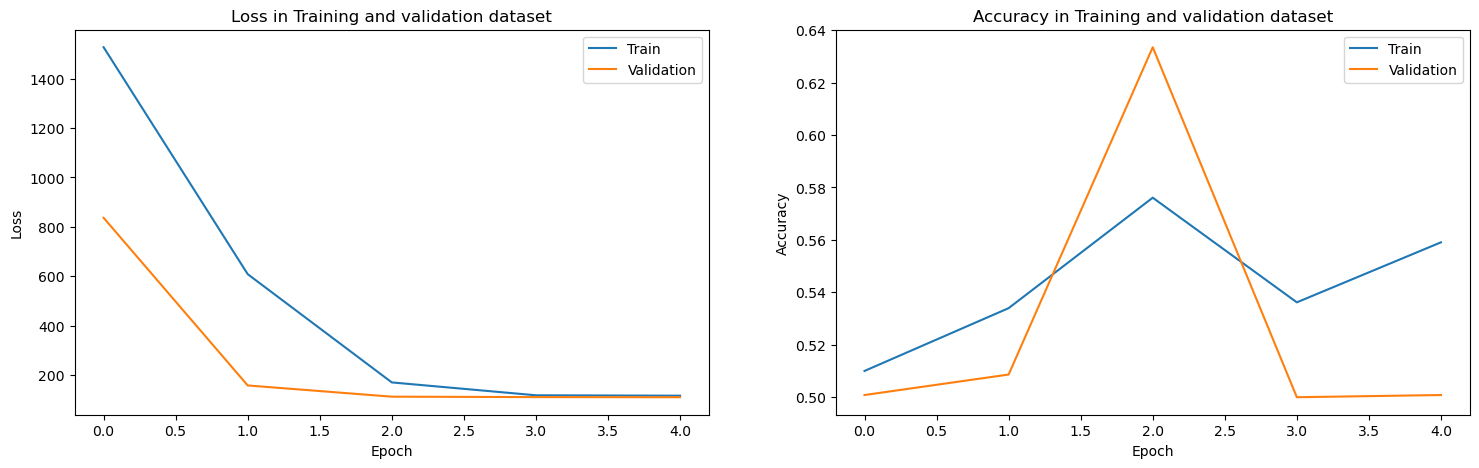

In [56]:
# YOUR CODE HERE
#import statistics as stat

print(len(train_losses_vgg))
print(len(val_losses_vgg))

train_vgg_means = [stat.mean(train_losses_vgg[i:i+int(len(train_losses_vgg)/len(val_losses_vgg))]) for i in range(0, len(train_losses_vgg), int(len(train_losses_vgg)/len(val_losses_vgg)))]
#print(len(train_means))
train_accs_vgg_means = [stat.mean(train_accs_svgg[i:i+int(len(train_losses_vgg)/len(val_losses_vgg))]) for i in range(0, len(train_accs_svgg), int(len(train_losses_vgg)/len(val_losses_vgg)))]
fig = plt.figure(figsize=(18,5))


# Plot for loss in the training and validation datasets
plt.subplot(1,2,1)
plt.plot(train_vgg_means)
plt.plot(val_losses_vgg)
plt.title('Loss in Training and validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot for accuracy in the training and validation datasets
plt.subplot(1,2,2)
plt.plot(train_accs_vgg_means)
plt.plot(val_accs_vgg)
plt.title('Accuracy in Training and validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# printing the corresponding plots
plt.show()

**(2 points)**

How does the model perform, compared to the model obtained in step 3? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

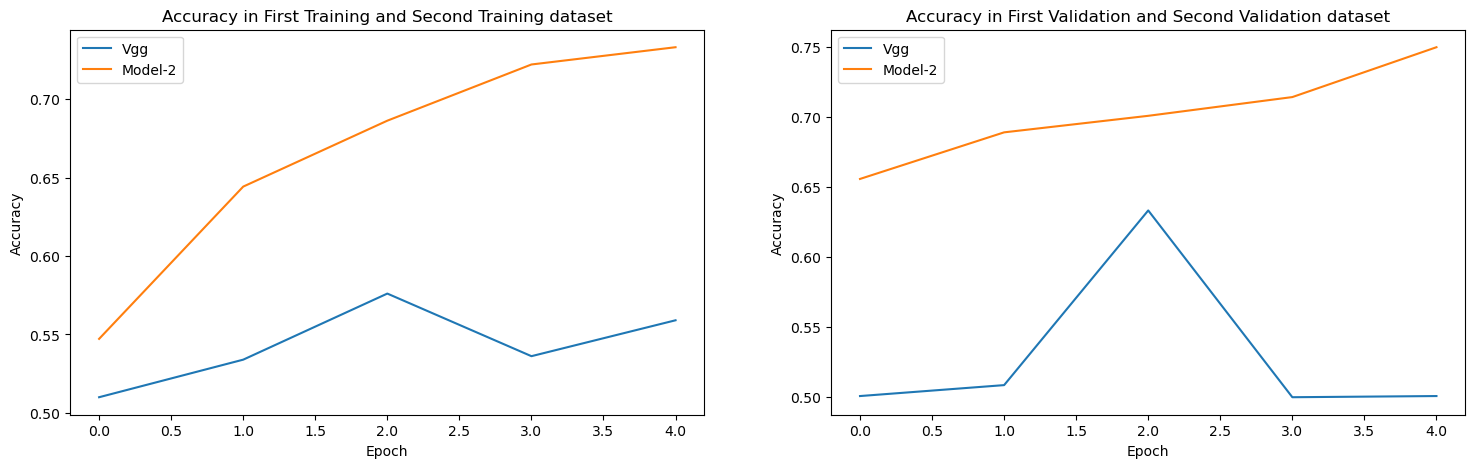

In [57]:
# YOUR CODE HERE

# YOUR CODE HERE

fig = plt.figure(figsize=(18,5))

# Plot for accuracy in the first training_1 and second training_2 datasets
plt.subplot(1,2,1)
plt.plot(train_accs_vgg_means)
plt.plot(train_accs_sec_means[0:5])
plt.title('Accuracy in First Training and Second Training dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Vgg', 'Model-2'])

# Plot for accuracy in the first validation and second validation datasets
plt.subplot(1,2,2)
plt.plot(val_accs_vgg)
plt.plot(val_accs_sec[0:5])
plt.title('Accuracy in First Validation and Second Validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Vgg', 'Model-2'])

# printing the corresponding plots
plt.show()

**(3 points)**

Compare these results. Which approach worked best, starting from scratch or doing transfer learning? Reflect on whether your comparison is fair or not:

**Your answer:** (fill in here)
-The model which was started fom scratch was better performing than doing transfer learning, as we can see from the graphs above. This as per our understanding is because the model built from scratch was trained upon the dogs and cats while the transfer learning features were frozen with parameters for training other images for multiple image classification.
-As the entire transfer learning model was not trained with the dataset, we think it is not fair to compare the models with varied trained weights

**(2 points)**

What are the main differences between the ImageNet dataset and the Dogs vs Cats dataset we used?

**Your answer:** (fill in here)
- The ImageNet dataset has over 1 million annotated images which can be used for classification. While Dogs vs Cats dataset has only over 25000 annotated images to classify.
- The ImageNet dataset has over 20000 categories where as dogs vs cats dataset has only 2 namely, dogs and cats.
- The ImageNet dataset is used for classifying massive number of objects including cars, chairs, flowers and many more. The dogs vs cats dataset is more specific to just dogs and cats.
- The ImageNet dataset would require a multi-class classifier CNN where as dogs vs cats dataset would be solved with a binary classifier CNN.
- The processing time required to train a model with ImageNet dataset would be significantly larger than the dogs vs cats dataset.

**(2 points)**

Even though there are considerable differences between these datasets, why is it that transfer learning is still a good idea?

**Your answer:** (fill in here)
Transfer learning already has well developed layers and weight parameters which will reduce time designing a new network. We can just adjust the top layers to our custom needs and reep the benefits of the well built network. The more layers also helps on a extensive feature extraction compared to the smaller model built by us. The pre-trained models have weights can be conveniently used for our models' usage, thus again reducing burden on computation and time.

**(1 point)**

In which scenario would transfer learning be unsuitable?

**Your answer:** (fill in here)
- In this case, using VGG is useful as it can be used for classification. But if the domains of using the model changes, then the VGG model becomes useless.
- We always have to understand the model before we can append our custom model to the base of the other model. In certain cases, if we're unavailable with the model, it will become very difficult to utilize the transfer learning capabilities.
- Transfer learning is usually done with deep and complex models as base. If we're unavailable with enough computational resources, these models cannot be used.

Save the model to a file.

In [31]:
# YOUR CODE HERE

# Assuming that you named your model "impr_model"
torch.save({'model_state_dict': vgg_model.state_dict(),
            'train_losses': train_losses_vgg,
            'train_accs': train_accs_svgg,
            'val_losses': val_losses_vgg,
            'val_accs': val_accs_vgg,
            }, "./third_model.ckpt")

### 4.2 Fine-tuning

Now that we have a better starting point for the top layers, we can train the entire network. Unfreeze the bottom layers by resetting the `requires_grad` attribute to `True`.

In [32]:
# YOUR CODE HERE
for param in vgg_model.features.parameters():
    param.requires_grad = True

**(1 point)**

Fine tune the model by training all the layers.

In [33]:
# YOUR CODE HERE
import torch.optim.lr_scheduler as lr_scheduler
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#loss_fn = nn.CrossEntropyLoss() #computes the softmax and loss function
loss_fn = nn.BCEWithLogitsLoss()

vgg_model_test_all, train_losses_vgg_all, train_accs_vgg_all, val_losses_vgg_all, val_accs_vgg_all = training_loop(vgg_model, optimizer, loss_fn, train_dataloader, val_dataloader, 5, 50)

Starting training
Using GPU
	Batch 50/55: 	Train loss: 0.148, 	Train acc.: 0.935, 	Val. loss: 0.106, 	Val. acc.: 0.963
Epoch 1/5: Train loss: 0.142, Train acc.: 0.939, Val. loss: 0.061, Val. acc.: 0.982
	Batch 50/55: 	Train loss: 0.088, 	Train acc.: 0.970, 	Val. loss: 0.050, 	Val. acc.: 0.982
Epoch 2/5: Train loss: 0.084, Train acc.: 0.971, Val. loss: 0.051, Val. acc.: 0.982
	Batch 50/55: 	Train loss: 0.027, 	Train acc.: 0.991, 	Val. loss: 0.069, 	Val. acc.: 0.980
Epoch 3/5: Train loss: 0.027, Train acc.: 0.991, Val. loss: 0.054, Val. acc.: 0.983
	Batch 50/55: 	Train loss: 0.017, 	Train acc.: 0.993, 	Val. loss: 0.106, 	Val. acc.: 0.971
Epoch 4/5: Train loss: 0.021, Train acc.: 0.992, Val. loss: 0.097, Val. acc.: 0.961
	Batch 50/55: 	Train loss: 0.034, 	Train acc.: 0.988, 	Val. loss: 0.085, 	Val. acc.: 0.974
Epoch 5/5: Train loss: 0.032, Train acc.: 0.988, Val. loss: 0.074, Val. acc.: 0.978


**(1 point)**

How does the model perform, compared to the model trained with frozen layers? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

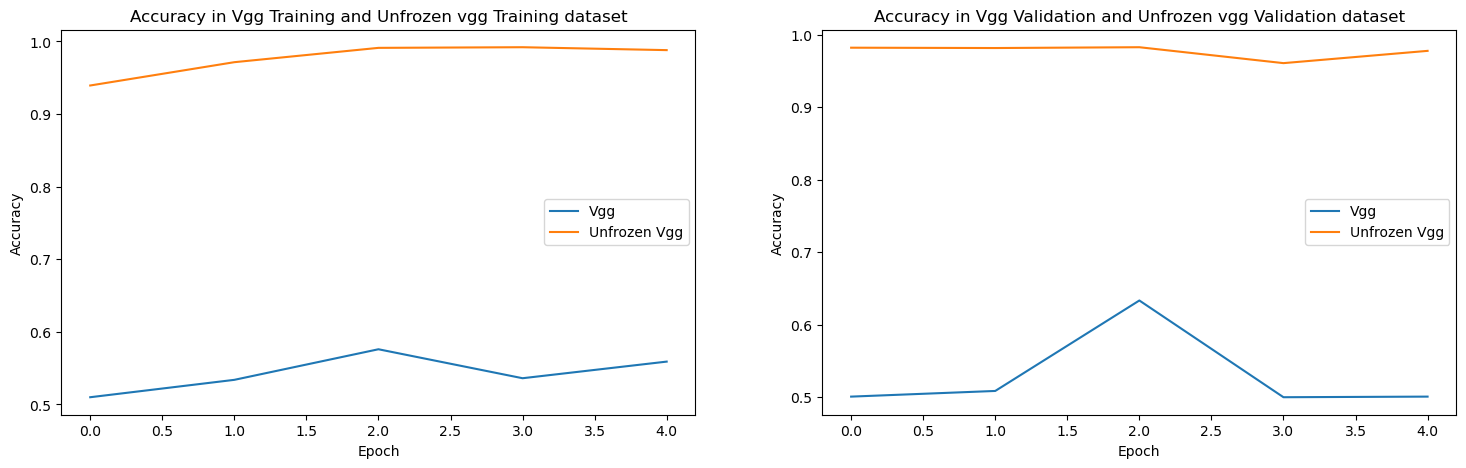

In [38]:
# YOUR CODE HERE
#print(len(train_losses_vgg))
#print(len(val_losses_vgg))

train_accs_vgg_all_means = [stat.mean(train_accs_vgg_all[i:i+int(len(train_accs_vgg_all)/len(val_accs_vgg_all))]) for i in range(0, len(train_accs_vgg_all), int(len(train_accs_vgg_all)/len(val_accs_vgg_all)))]


fig = plt.figure(figsize=(18,5))

# Plot for accuracy in the first training_1 and second training_2 datasets
plt.subplot(1,2,1)
plt.plot(train_accs_vgg_means)
plt.plot(train_accs_vgg_all_means)
plt.title('Accuracy in Vgg Training and Unfrozen vgg Training dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Vgg', 'Unfrozen Vgg'])

# Plot for accuracy in the first validation and second validation datasets
plt.subplot(1,2,2)
plt.plot(val_accs_vgg)
plt.plot(val_accs_vgg_all)
plt.title('Accuracy in Vgg Validation and Unfrozen vgg Validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Vgg', 'Unfrozen Vgg'])

# printing the corresponding plots
plt.show()


**(2 points)**

Why is it a good idea to use a very small learning rate when doing fine tuning?

**Your answer:** (fill in here)
The weights are adjusted based on the loss function and its results. When a loss is notified, the weights are adjusted according to the learning rate. If the learning rate is too high, we would oscilate largely from the optimal values on the weights and in some cases, never converge. But by reducing this rate, it might take longer to reach convergence but we are more guaranteed for a smooth convergence.

Save the model to file.

In [39]:
# YOUR CODE HERE
# Assuming that you named your model "impr_model"
torch.save({'model_state_dict': vgg_model_test_all.state_dict(),
            'train_losses': train_losses_vgg_all,
            'train_accs': train_accs_vgg_all,
            'val_losses': val_losses_vgg_all,
            'val_accs': val_accs_vgg_all,
            }, "./fourth_model.ckpt")



### 4.3 Improving the top model (optional)

Improve the architecture for the layers you add on top of VGG16. Try different ideas! When you're happy with one architecture, copy it in the cell below and train it here.

In [ ]:
# YOUR CODE HERE

**(1 point)**

How does the model perform, compared to the model trained in step 4.2? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [ ]:
# YOUR CODE HERE

Save the model to a file.

In [ ]:
# YOUR CODE HERE

## 5. Final training

Now we'll train the model that achieved the best performance so far using the entire dataset.

**Note**: start the optimization with the weights you obtained training in the smaller subset, i.e. *not* from scratch.

First, create two new data loaders, one for training samples and one for validation samples. This time, they'll load data from the folders for the entire dataset.

In [19]:
# YOUR CODE HERE
transform_fullset = Compose([Resize((224, 224)), RandomHorizontalFlip(),RandomRotation(10),ToTensor(),Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset_fullset = DogsCatsData(train_path,transform_fullset)
val_dataset_fullset = DogsCatsData(val_path,transform_fullset)

train_dataloader_fullset = DataLoader(train_dataset_fullset, batch_size=64, shuffle = True)
val_dataloader_fullset = DataLoader(val_dataset_fullset, batch_size=64, shuffle=True)

for param in vgg_model.features.parameters():
    param.requires_grad = False

**(1 point)**

Train your model using the full data. This optimization might take a long time.

In [21]:
# YOUR CODE HERE
# YOUR CODE HERE
import torch.optim.lr_scheduler as lr_scheduler
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_fn = nn.BCEWithLogitsLoss()

vgg_model_test_fullset, train_losses_vgg_fullset, train_accs_vgg_fullset, val_losses_vgg_fullset, val_accs_vgg_fullset = training_loop(vgg_model, optimizer, loss_fn, train_dataloader_fullset, val_dataloader_fullset, 2, 70)

Starting training
Using GPU
	Batch 70/313: 	Train loss: 0.095, 	Train acc.: 0.962, 	Val. loss: 0.046, 	Val. acc.: 0.980
	Batch 140/313: 	Train loss: 0.053, 	Train acc.: 0.979, 	Val. loss: 0.047, 	Val. acc.: 0.980
	Batch 210/313: 	Train loss: 0.059, 	Train acc.: 0.979, 	Val. loss: 0.063, 	Val. acc.: 0.969
	Batch 280/313: 	Train loss: 0.054, 	Train acc.: 0.979, 	Val. loss: 0.040, 	Val. acc.: 0.984
Epoch 1/2: Train loss: 0.064, Train acc.: 0.975, Val. loss: 0.040, Val. acc.: 0.985
	Batch 70/313: 	Train loss: 0.039, 	Train acc.: 0.985, 	Val. loss: 0.041, 	Val. acc.: 0.986
	Batch 140/313: 	Train loss: 0.039, 	Train acc.: 0.988, 	Val. loss: 0.038, 	Val. acc.: 0.985
	Batch 210/313: 	Train loss: 0.045, 	Train acc.: 0.984, 	Val. loss: 0.059, 	Val. acc.: 0.983
	Batch 280/313: 	Train loss: 0.033, 	Train acc.: 0.988, 	Val. loss: 0.040, 	Val. acc.: 0.984
Epoch 2/2: Train loss: 0.039, Train acc.: 0.986, Val. loss: 0.045, Val. acc.: 0.981


**(1 point)**

How does the model perform now when trained on the entire dataset, compared to when only trained on the smaller subset of data? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

275
5


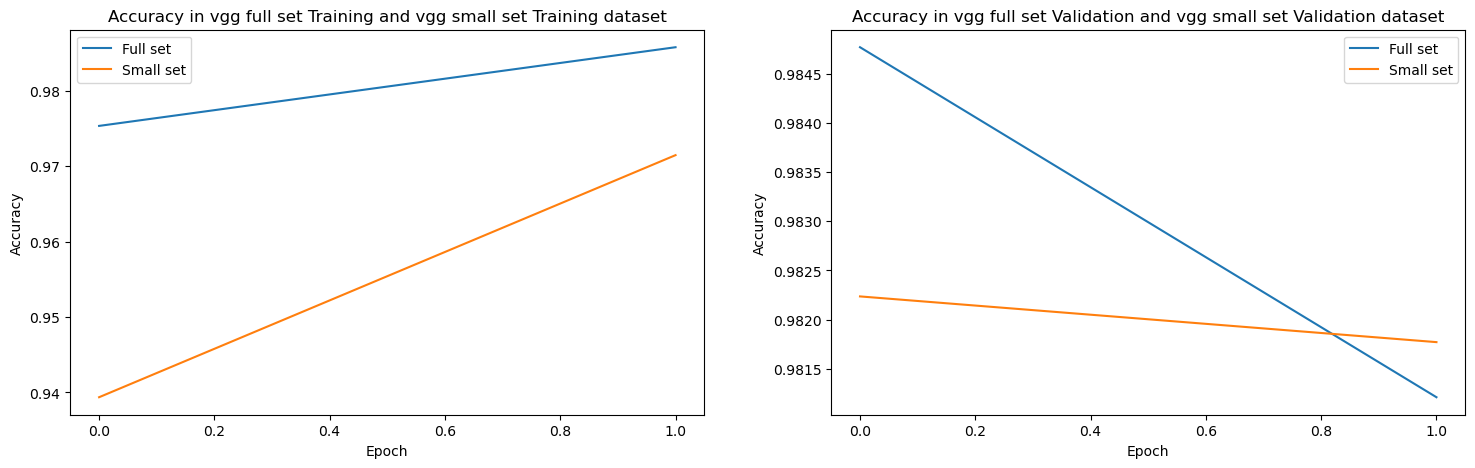

In [42]:
# YOUR CODE HERE
print(len(train_losses_vgg))
print(len(val_losses_vgg))

train_accs_vgg_fullset_means = [stat.mean(train_accs_vgg_fullset[i:i+int(len(train_accs_vgg_fullset)/len(val_accs_vgg_fullset))]) for i in range(0, len(train_accs_vgg_fullset), int(len(train_accs_vgg_fullset)/len(val_accs_vgg_fullset)))]


fig = plt.figure(figsize=(18,5))

# Plot for accuracy in the first training_1 and second training_2 datasets
plt.subplot(1,2,1)
plt.plot(train_accs_vgg_fullset_means)
plt.plot(train_accs_vgg_all_means[0:2])
plt.title('Accuracy in vgg full set Training and vgg small set Training dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Full set', 'Small set'])

# Plot for accuracy in the first validation and second validation datasets
plt.subplot(1,2,2)
plt.plot(val_accs_vgg_fullset)
plt.plot(val_accs_vgg_all[0:2])
plt.title('Accuracy in vgg full set Validation and vgg small set Validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Full set', 'Small set'])

# printing the corresponding plots
plt.show()

**(2 points)**

What can you conclude from these plots? Did you expect what you observe in the plots, explain!

**Your answer:** (fill in here)
- The plots conclude that the accuracy on the training and validation are very similar. This is expected as the entire model was trained on dogs vs cats smaller set which is very similar to the dataset present on the larger dataset. Thus the feature parameters didn't have to be changed for the larger dataset.
- We expected this performance and it was validated by the plots above.

Save the model to a file.

In [22]:
# YOUR CODE HERE
torch.save({'model_state_dict': vgg_model_test_fullset.state_dict(),
            'train_losses': train_losses_vgg_fullset,
            'train_accs': train_accs_vgg_fullset,
            'val_losses': val_losses_vgg_fullset,
            'val_accs': val_accs_vgg_fullset,
            }, "./sixth_model.ckpt")

## 6. Evaluation on test set (optional)

Now we'll evaluate your final model, obtained in step 6, on the test set. As mentioned before, the samples in the test set are not labelled, so we can't compute any supervised performance metrics ourselves. 

As a bit of fun and to inspire some friendly competition you may instead submit it to Kaggle for evaluation.

Compute the predictions for all samples in the test set according to your best model, and save it in a .csv file with the format expected by the competition.

For the test data we need a slightly different dataset class, due to the lack of labels in the data.
A more proper way to implement it would be to make a common class which handles both the train and test settings.
Here, we'll just copy the train dataset class and make some modifications to ignore the labels.

Hints:
- There is a `sampleSubmission.csv` file included in the zip data. Take a look at it to better understand what is the expected format here.
- If you don't know how to create and write to files with Python, it's a well-behaved Google search.

In [ ]:
from pathlib import Path
from PIL import Image
from time import time

class TestData(Dataset):
    
    def __init__(self, root: Path, transform):
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")
            
        self.root = root
        self.transform = transform
        self._samples = self._collect_samples()
            
    def __getitem__(self, index):
        path = self._samples[index]
        num_id = int(path.stem)
        img = Image.open(path)
        if self.transform is not None:
            img = self.transform(img) 
        return img, num_id
    
    def __len__(self):
        return len(self._samples)
    
    def _collect_samples(self):
        test_paths = self._collect_imgs_sub_dir(self.root)
        return sorted(list(test_paths), key=lambda path: int(path.stem))
     
    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.jpg")
    
    def get_sample_by_id(self, id_):
        id_index = self._samples.index(id_)
        return self[id_index]

# YOUR CODE HERE


Now that you created your submission file, submit it to Kaggle for evaluation. The [old competition](https://www.kaggle.com/c/dogs-vs-cats) does not allow submissions any more, but you can submit your file to the [new one](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) via the "Late submission" button (they use the same data). The Kaggle CLI can be used as well. Kaggle evaluates your submission according to your log-loss score. Which score did you obtain?

**Your answer:** (fill in here)

What was the username you used for this submission?

**Your answer:** (fill in here)

In [1]:
##################################################################
# Reproducing the paper                                          #
# ENet - Real Time Semantic Segmentation                         #
# Paper: https://arxiv.org/pdf/1606.02147.pdf                    #
#                                                                #
# Copyright (c) 2019                                             #
# Authors: @iArunava <iarunavaofficial@gmail.com>                #
#          @AvivSham <mista2311@gmail.com>                       #
#                                                                #
# License: BSD License 3.0                                       #
#                                                                #
# The Code in this file is distributed for free                  #
# usage and modification with proper credits                     #
# directing back to this repository.                             #
##################################################################

import torch
import torch.nn as nn
from .InitialBlock import InitialBlock
from .RDDNeck import RDDNeck
from .UBNeck import UBNeck
from .ASNeck import ASNeck

class ENet(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        self.C = C
        
        # The initial block
        self.init = InitialBlock()
        
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The fourth bottleneck
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
        
    def forward(self, x):
        
        # The initial block
        x = self.init(x)
        
        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        
        return x



ImportError: attempted relative import with no known parent package